# Project description
The service for the sale of used cars "Not damaged, not painted" is developing an application to attract new customers. In it you can quickly find out the market value of your car. Historical data is at your disposal: technical characteristics, equipment and prices of cars. You need to build a model to estimate the price of a used car.

Important for the customer:

- prediction quality
- prediction speed
- learning duration


# Data description
The data is in the `autos.csv` file.

Columns:
* DateCrawled - date of downloading the profile from the database
* VehicleType - type of car body
* RegistrationYear - year of vehicle registration
* Gearbox - type of gearbox
* Power - power (l. From.)
* Model - car model
* Kilometer - mileage (km)
* RegistrationMonth - month of vehicle registration
* FuelType - type of fuel
* Brand - car brand
* NotRepaired - was the car under repair or not
* DateCreated - the date the profile was created
* NumberOfPictures - number of car photos
* PostalCode - postal code of the profile owner (user)
* LastSeen - date of last user activity

Target value: *Price* (car price in €)

### Содержание <a id='content'></a>

[**1. Data preprocessing.**](#step1)
   * [*1.1 Data overview.*](#step1.1)
   * [*1.2 Missing values and anomalies.*](#step1.2)   
   * [*1.3 Correlation matrix.*](#step1.3)
   * [*1.4 Coding categorical features.*](#step1.4)
   * [*1.5 Data scaling.*](#step1.5) 

[**2. Train the model.**](#step2)
   * [*2.1 Model 1 - Linear Regression.*](#step2.1)
   * [*2.2 Model 2 - RandomForestRegressor.*](#step2.2)
   * [*2.3 Model 3 - LGBMRegressor.*](#step2.3)
   * [*2.4 Model 4 - CatBoostRegressor.*](#step2.4)
   
[**3. Model analysis.**](#step3)

[**4. Summary.**](#step4)

# 1. Data preprocessing  <a class="anchor" id="step1"></a>
[back to content](#content)

## 1. Data overview  <a class="anchor" id="step1.1"></a>
[back to content](#content)

Import libraries:

In [29]:
import pandas as pd
import numpy as np
import catboost as cb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 666

import warnings
warnings.filterwarnings("ignore")

We load data and immediately parse the columns with dates:

In [6]:
df = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

Let's write down some functions for further work:

In [27]:
def dataset_overview(df):
    """Display a table with dataset statistics like size, missing values, duplicates etc.
    Parameters
    ----------
    df: pandas DataFrame
        Dataset to display infromation about.
    Returns
    -------
    DataFrame
        Resulting table as pandas dataframe.
    """
    #calculate values for table
    number_of_columns = df.shape[1]
    number_of_rows = df.shape[0]  
    missing_cells_number = df.isnull().sum().sum()
    missing_cells_ratio = missing_cells_number / (number_of_rows * number_of_columns)
    duplicate_rows_number = df.duplicated().sum()
    duplicate_rows_ratio = duplicate_rows_number / number_of_rows
    df_memory_size = np.round((df.memory_usage().sum() / 1000000), 2)
    datetime_col_number = len([c for c in df.columns if pd.api.types.is_datetime64_any_dtype(df[c]) == True])
    object_col_number = len([c for c in df.columns if pd.api.types.is_object_dtype(df[c]) == True])
    num_col_number = len([c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) == True])
    bool_col_number = len([c for c in df.columns if pd.api.types.is_bool_dtype(df[c]) == True])
    #create dataframe table
    result_table = pd.DataFrame([number_of_columns,number_of_rows,missing_cells_number,
                                 '{:.2%}'.format(missing_cells_ratio), duplicate_rows_number,
                                 '{:.2%}'.format(duplicate_rows_ratio),(str(df_memory_size) + " MiB"),
                                 datetime_col_number,object_col_number,num_col_number,bool_col_number],
                                index=['Number of variables','Number of observations','Missing cells',
                                       'Missing cells (%)','Duplicate rows', 'Duplicate rows (%)',
                                       'Total size in memory','DATETIME variables','CATEGORICAL variables',
                                       'NUMERICAL variables', 'BOOL variables'], columns=['value'])
    
    print('Dataset overview')
    return result_table


def num_var_overview(df):
    """Display a table with statistics for numerical variables like size, missing values, zeros etc.
    Parameters
    ----------
    df: pandas DataFrame
        Dataset to display infromation about.
    Returns
    -------
    DataFrame
        Resulting table as pandas dataframe.
    """
    #find numerical columns
    cat_var = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) == True]
    #column names for result table
    columns = ['Rows', 'Unique values', 'Unique values (%)', 'Missing values', 'Missing values (%)',
               'Mean', 'Median', 'Minimum', 'Maximum', 'Zeros', 'Zeros (%)']
    
    #create resutl table
    result_table = pd.DataFrame([], columns=columns, index=cat_var)
    for var in result_table.index:
        result_table.loc[var, 'Rows'] = df.shape[0]
        result_table.loc[var, 'Unique values'] = len(df[var].unique())
        result_table.loc[var, 'Unique values (%)'] = np.round((len(df[var].unique()) / df.shape[0]), 4)
        result_table.loc[var, 'Missing values'] = df[var].isnull().sum()
        result_table.loc[var, 'Missing values (%)'] =  np.round((df[var].isnull().sum() / df.shape[0]), 4)
        result_table.loc[var, 'Mean'] =  np.round(df[var].mean(), 2)
        result_table.loc[var, 'Median'] =  np.round(df[var].median(), 2)
        result_table.loc[var, 'Minimum'] =  df[var].min()
        result_table.loc[var, 'Maximum'] =  df[var].max()
        result_table.loc[var, 'Zeros'] =  df[df[var] == 0].count()[var]
        result_table.loc[var, 'Zeros (%)'] =  np.round((df[df[var] == 0].count()[var] / df.shape[0]), 4) 
    
    #convert datatypes
    result_table = result_table.astype(float)
    
    formatter = {'Unique values (%)': '{:,.2%}','Missing values (%)': '{:,.2%}', 'Zeros (%)': '{:,.2%}'}
    
    print('Numerical variables overview')
    return result_table.style.format(formatter).background_gradient(
        subset=['Unique values','Missing values','Zeros'], cmap='coolwarm')
        

def check_removed_data(data_start, data_end):
    '''function for calculating the proportion of deleted data during processing'''
    rows_removed = (data_start.shape[0] - data_end.shape[0]) / data_start.shape[0]
    cols_removed = (data_start.shape[1] - data_end.shape[1]) / data_start.shape[1]
    
    result = 'At this stage {:.2%} rows and {:.2%} columns were deleted.'.format(rows_removed,
                                                                                 cols_removed)
    return result


def split_data(df, test_size, features, target):
    '''function for automatically 
    splitting data into training and test samples'''
    df_train, df_valid = train_test_split(df,test_size=test_size,
                                            random_state=random_state,
                                            shuffle=True)
 
    features_train = df_train[features]
    target_train = df_train[target]
    features_valid =df_valid[features]
    target_valid = df_valid[target]
    
    return features_train, target_train, features_valid, target_valid


def cross_validation(model, features, target, cv):
    '''function to check the model for cross-validation'''
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    result = cross_validate(model, features, target, scoring=mse_scorer, cv=cv)
    
    avg_test_score = np.abs(np.mean(result['test_score']))
    
    return np.round((avg_test_score ** 0.5), 2)


def find_best_hyperparams(features, target, model, param_grid,
                          cv=5, scoring='neg_mean_squared_error'):
    '''use GridSearchCV to find best model hyperparameters. Returns GS result object.'''
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=2)
    
    result = gs.fit(features, target)
    
    return result


def print_rmse_cv(rmse_valid):
    '''print model RMSE'''
    print('RMSE on cross validation: {}'.format(rmse_valid))

    
def plot_distplot(data, title, xlabel, ylabel, figsize=(10,6)):
    '''plot a seaborn histogram'''
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.distplot(data)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
    
def plot_barchart(data, x, y, title, xlabel, ylabel, figsize=(10,6), xlabel_rotation=None):
    '''plot a seaborn barchart'''
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.barplot(data=data, x=x, y=y)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=xlabel_rotation)


def get_mode(x):
    '''get most frequent value in a column:
    for usage as groupby aggregation function'''
    try:
        return x.value_counts().index[0]
    except:
        return np.nan


def fill_missing_values(row, column):
    '''fill missing values in specified column from "cat_data_groupby"'''
    if pd.isna(row[column]) and column != 'Power':
        try:
            return cat_data_groupby[(cat_data_groupby.Brand == row.Brand) & \
                   (cat_data_groupby.RegistrationYear == row.RegistrationYear)]\
                   [column].values[0]
        except:
            return row[column]
    elif column == 'Power' and row[column] ==0:
        try:
            return cat_data_groupby[(cat_data_groupby.Brand == row.Brand) & \
                   (cat_data_groupby.RegistrationYear == row.RegistrationYear)]\
                   [column].values[0]
        except:
            return row[column]       
    else:
        return row[column]

Let's look at the general information about the dataset:

In [8]:
dataset_overview(df)

Dataset overview


,value
Number of variables,16
Number of observations,354369
Missing cells,181077
Missing cells (%),3.19%
Duplicate rows,4
Duplicate rows (%),0.00%
Total size in memory,45.36 MiB
DATETIME variables,3
CATEGORICAL variables,6
NUMERICAL variables,7


Three random rows:

In [9]:
df.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
222803,2016-03-30 20:44:56,0,other,1986,auto,90,NaN,70000,7,petrol,sonstige_autos,yes,2016-03-30,0,24837,2016-04-07 12:46:38
54814,2016-03-22 19:41:21,6000,small,2012,auto,75,twingo,30000,2,petrol,renault,no,2016-03-22,0,48157,2016-04-06 12:15:57
202992,2016-03-16 11:36:44,1500,wagon,2001,manual,192,5er,150000,6,petrol,bmw,no,2016-03-16,0,96476,2016-03-16 11:36:44


Let's look at the numeric parameters:

In [10]:
num_var_overview(df)

Numerical variables overview


,Rows,Unique values,Unique values (%),Missing values,Missing values (%),Mean,Median,Minimum,Maximum,Zeros,Zeros (%)
Price,354369.000000,3731.000000,1.05%,0.000000,0.00%,4416.660000,2700.000000,0.000000,20000.000000,10772.000000,3.04%
RegistrationYear,354369.000000,151.000000,0.04%,0.000000,0.00%,2004.230000,2003.000000,1000.000000,9999.000000,0.000000,0.00%
Power,354369.000000,712.000000,0.20%,0.000000,0.00%,110.090000,105.000000,0.000000,20000.000000,40225.000000,11.35%
Kilometer,354369.000000,13.000000,0.00%,0.000000,0.00%,128211.170000,150000.000000,5000.000000,150000.000000,0.000000,0.00%
RegistrationMonth,354369.000000,13.000000,0.00%,0.000000,0.00%,5.710000,6.000000,0.000000,12.000000,37352.000000,10.54%
NumberOfPictures,354369.000000,1.000000,0.00%,0.000000,0.00%,0.000000,0.000000,0.000000,0.000000,354369.000000,100.00%
PostalCode,354369.000000,8143.000000,2.30%,0.000000,0.00%,50508.690000,49413.000000,1067.000000,99998.000000,0.000000,0.00%


Let's look at the categorical signs:

In [11]:
df.describe(include=['object'])

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


Let's look at the date columns:

In [14]:
df.DateCrawled.describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-21 12:58:10.450648320
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [15]:
df.DateCreated.describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-20 19:12:07.753274112
min                2014-03-10 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [16]:
df.LastSeen.describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-29 23:51:00.667456768
min                2016-03-05 14:15:08
25%                2016-03-23 02:50:03
50%                2016-04-03 15:15:51
75%                2016-04-06 10:15:19
max                2016-04-07 14:58:51
Name: LastSeen, dtype: object

### Summary

There is work to do:

* handling missing values
* handling zero values, in the price for example
* implausible values, for example, the year of registration is 9999 or 1000
* the *NumberOfPictures* column can be deleted immediately, it contains the constant *0*
* categorical variables have to be coded to numerical
* remove unnecessary features, for example, the date of the ad

## 1.2 Missing values and anomalies  <a class="anchor" id="step1.2"></a>
[back to content](#content)

In [17]:
#backup
df_clean = df.copy()

Let's check for duplicates and remove them:

In [18]:
df_clean.duplicated().sum()

4

In [19]:
df_clean = df_clean.drop_duplicates()

In [20]:
#immediately remove unnecessary columns with the number of images and dates
df_clean = df_clean.drop(['NumberOfPictures', 'DateCrawled',
                          'RegistrationMonth','LastSeen',
                          'DateCreated', 'PostalCode'], axis=1)

Let's take a look at the target value:

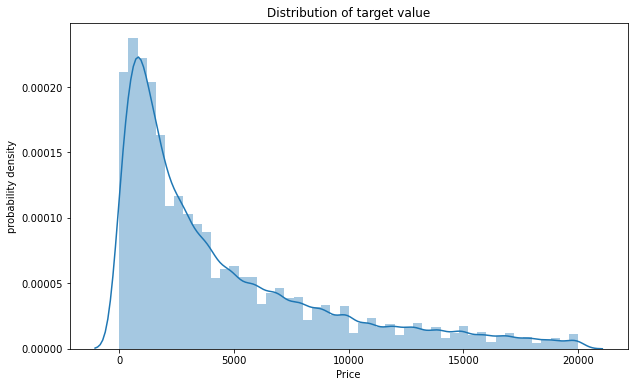

In [30]:
plot_distplot(df_clean['Price'], 'Distribution of target value',
              'Price', 'probability density')

Zero prices do not carry information, we will delete them. Let's leave the high prices for more expensive cars.

In [31]:
df_clean = df_clean[df_clean['Price'] > 0]

Let's process anomalous values in the year of registration, leaving a realistic period with oldtimers from 1950 to 2020:

In [32]:
df_clean = df_clean[(df_clean['RegistrationYear'] < 2020) & (df_clean['RegistrationYear'] > 1950)]

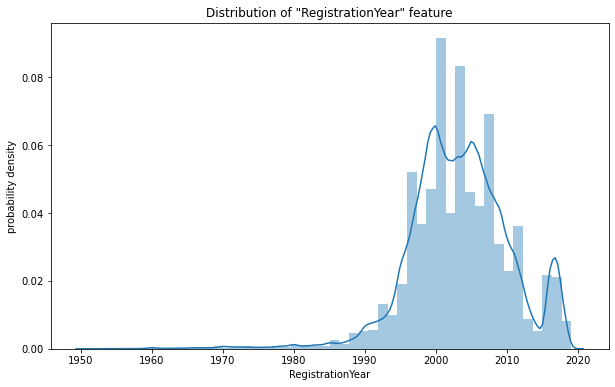

In [33]:
plot_distplot(df_clean['RegistrationYear'], 'Distribution of "RegistrationYear" feature',
              'RegistrationYear', 'probability density')

We will fill the missing values in *NotRepaired* column with a new category "unknown":

In [34]:
df_clean.NotRepaired = df_clean.NotRepaired.fillna(value='unknown')

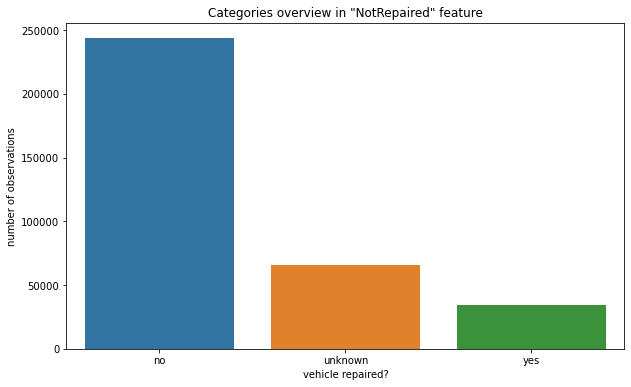

In [35]:
plot_barchart(df_clean.NotRepaired.value_counts().reset_index(), 
              'index', 'NotRepaired', 'Categories overview in "NotRepaired" feature',
              'vehicle repaired?', 'number of observations')

Missing values in 'VehicleType', 'Gearbox', 'Model', 'FuelType' as well as zero values in "Power" we will try to fill in with the most common values / median from the available data. Let's create a pivot table from which we will search for information on car brands and year of manufacturing (these signs have no missing data) for missing values.

In [36]:
%%time
cat_data_groupby = df_clean.dropna().groupby(
    ['Brand','RegistrationYear'])\
    ['VehicleType','Gearbox','Model','FuelType', 'Power'].agg(
    {'VehicleType': get_mode,
     'Gearbox': get_mode,
     'Model':get_mode,
     'FuelType':get_mode,
     'Power': 'median'}).reset_index()

CPU times: user 3.12 s, sys: 6.33 ms, total: 3.13 s
Wall time: 3.13 s


In [37]:
cat_data_groupby.sample(3)

,Brand,RegistrationYear,VehicleType,Gearbox,Model,FuelType,Power
418,fiat,2013,small,manual,500,petrol,69.0
325,daewoo,1998,sedan,manual,nubira,petrol,100.0
141,bmw,1999,sedan,manual,3er,petrol,150.0


Now let's use a function `fill_missing_values` to fill in the gaps with a pivot table:

In [38]:
%%time
df_clean['FuelType'] = df_clean.apply(
    lambda row: fill_missing_values(row, 'FuelType'), axis=1)

CPU times: user 24.8 s, sys: 67.5 ms, total: 24.8 s
Wall time: 24.8 s


In [39]:
%%time
df_clean['VehicleType'] = df_clean.apply(
    lambda row: fill_missing_values(row, 'VehicleType'), axis=1)

CPU times: user 27.8 s, sys: 46.5 ms, total: 27.8 s
Wall time: 27.9 s


In [40]:
%%time
df_clean['Gearbox'] = df_clean.apply(
    lambda row: fill_missing_values(row, 'Gearbox'), axis=1)

CPU times: user 15.9 s, sys: 63.6 ms, total: 15.9 s
Wall time: 15.9 s


In [41]:
%%time
df_clean['Model'] = df_clean.apply(
    lambda row: fill_missing_values(row, 'Model'), axis=1)

CPU times: user 16.1 s, sys: 59.6 ms, total: 16.1 s
Wall time: 16.1 s


In [42]:
%%time
df_clean['Power'] = df_clean.apply(
    lambda row: fill_missing_values(row, 'Power'), axis=1)

CPU times: user 30.6 s, sys: 59.9 ms, total: 30.6 s
Wall time: 30.6 s


Let's see how much missing data is left:

In [43]:
dataset_overview(df_clean)

Dataset overview


,value
Number of variables,10
Number of observations,343311
Missing cells,17124
Missing cells (%),0.50%
Duplicate rows,48708
Duplicate rows (%),14.19%
Total size in memory,30.21 MiB
DATETIME variables,0
CATEGORICAL variables,6
NUMERICAL variables,4


The amount of missing data was noticeably reduced. The rest of the gaps cannot be filled adequately, so we will delete them.

In [44]:
df_clean = df_clean.dropna(subset=['VehicleType', 'Gearbox', 'Model', 'FuelType'])

The 'Power' column contains zero and very high values. Let's remove these outliers.

In [45]:
df_clean = df_clean[(df_clean['Power'] < 600) & (df_clean['Power'] > 0)]

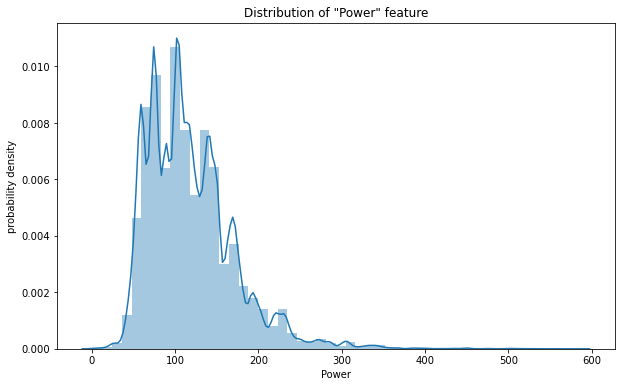

In [46]:
plot_distplot(df_clean.Power, 'Distribution of "Power" feature',
              'Power', 'probability density')

In [47]:
df_clean["Power"].describe()

count    332109.000000
mean        118.435672
std          52.128759
min           1.000000
25%          75.000000
50%         109.000000
75%         145.000000
max         585.000000
Name: Power, dtype: float64

Let's see how much data we deleted at this stage:

In [48]:
check_removed_data(df, df_clean)

'At this stage 6.28% rows and 37.50% columns were deleted.'

## 1.3 Correlation matrix  <a class="anchor" id="step1.3"></a>
[back to content](#content)

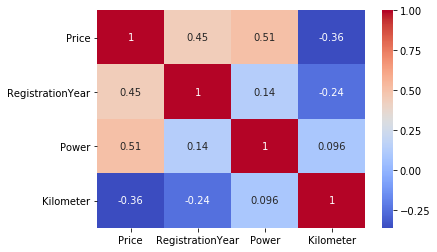

In [35]:
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')

There is no strong linear correlation between features.

## 1.4 Coding categorical features  <a class="anchor" id="step1.4"></a>
[back to content](#content)

In [49]:
#backup
df_encoded = df_clean.copy()

To code categorical features, we will use the *Ordinal Encoding* technique, since we have quite a lot of them and the *One Hot Encoding* technique is not optimal in this case.

In [50]:
#save categorical features in a list
cat_features = ['Gearbox', 'NotRepaired', 'VehicleType', 'Model', 'FuelType', 'Brand']

In [51]:
#OE with sklearn LabelEncoder
label_encoder = LabelEncoder()

for column in cat_features:
    df_encoded[column + '_enc'] = label_encoder.fit_transform(df_encoded[column])

df_encoded = df_encoded.drop(columns=cat_features)

In [52]:
df_encoded.sample(3)

,Price,RegistrationYear,Power,Kilometer,Gearbox_enc,NotRepaired_enc,VehicleType_enc,Model_enc,FuelType_enc,Brand_enc
15109,650,1993,113.0,125000,1,0,4,11,6,2
53109,600,2000,60.0,150000,1,1,5,173,6,37
286341,2098,2007,56.0,150000,1,0,4,107,2,37


## 1.5 Data scaling  <a class="anchor" id="step1.5"></a>
[back to content](#content)

In [53]:
#backup
df_scale = df_encoded.copy()

Let's standardize numerical features using *StandardScaler*:

In [54]:
#select columns for scaling and create a StandardScaler() object
scale_cols = ['Power', 'Kilometer', 'RegistrationYear']
scaler = StandardScaler()
scaler.fit(df_scale[scale_cols])

StandardScaler()

In [55]:
#feature standartization
df_scale.loc[:, scale_cols] = scaler.transform(df_scale[scale_cols])

In [56]:
df_scale.sample(3)

,Price,RegistrationYear,Power,Kilometer,Gearbox_enc,NotRepaired_enc,VehicleType_enc,Model_enc,FuelType_enc,Brand_enc
332604,2890,0.892785,-1.236089,-1.852499,1,1,5,169,6,9
104450,1350,-0.438221,-0.046724,0.575377,1,0,4,116,6,37
350507,1750,1.928012,-0.583857,0.575377,1,0,5,170,6,37


# 2. Train the model  <a class="anchor" id="step2"></a>
[back to content](#content)

Let's divide the initial data into two samples with sizes:
* training: 80%
* validation: 20%

In [57]:
#save training and target features in variables
target = 'Price'
features = df_scale.drop(['Price'], axis=1).columns.to_list()

In [58]:
#create samples for training and validation
features_train, target_train,\
features_valid, target_valid = split_data(df_scale, 0.2, features, target)

In [59]:
#посмотрим на размеры полученных датафреймов
print('Training data size: {}'.format(features_train.shape))
print('Validation data size: {}'.format(features_valid.shape))

Training data size: (265687, 9)
Validation data size: (66422, 9)


## 2.1 Model 1 - Linear Regression  <a class="anchor" id="step2.1"></a>
[back to content](#content)

Let's first create a simple model using linear regression and store the following metrics in variables:
* prediction quality (RMSE) in €
* prediction speed in seconds
* learning rate in seconds

The code execution time will be measured in cells by the magic function %% time. Time measurements may vary depending on the computer performance. For conviniece the results are hard coded in variable.

In [65]:
%%time
#build a linear regression model and measure the training time
model_reg = LinearRegression().fit(features_train, target_train)

CPU times: user 114 ms, sys: 4.06 ms, total: 118 ms
Wall time: 46.9 ms


In [66]:
#write the training time into a variable
reg_train_time = 0.049

In [67]:
%%time
#measure the prediction time
model_reg.predict(features_valid)

CPU times: user 4.86 ms, sys: 0 ns, total: 4.86 ms
Wall time: 5.18 ms


array([ 7207.06439313,  7092.83475167,  2121.62436897, ...,
        7613.22449854, -1416.88052254, -1671.5956014 ])

In [68]:
#save prediction time
reg_predict_time = 0.0033

In [69]:
#we will make cross-validation on test and validation
#samples and display the metrics on the screen
reg_rmse_valid = cross_validation(model_reg, features_valid, target_valid, 3)
print_rmse_cv(reg_rmse_valid)

RMSE on cross validation: 2980.16


Quite high RMSE considering the small range of the target value. Apparently there are no linear dependencies.

In [70]:
df_clean[target].describe()

count    332109.000000
mean       4580.576103
std        4523.268447
min           1.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

## 2.2 Model 2 - RandomForestRegressor  <a class="anchor" id="step2.2"></a>
[back to content](#content)

Let's build a random forest model. In order not to wait for the code to execute, the results are copied in advance in the markdown cells and the variables are written manually.

In [71]:
model_rfr = RandomForestRegressor(random_state=random_state)

rfr_param_grid = {'n_estimators': [100, 400],
                   'max_depth': [10,15],
                  }

Best hyperparameters:

Learning time:

In [72]:
rfr_train_time = 172

In [73]:
rfr_rmse_valid = 1723

Prediction time:

In [74]:
rfr_predict_time = 4

The quality of the model is significantly improved over linear regression. The training and prediction time is certainly an order of magnitude higher.

## 2.3 Model 3 - LGBMRegressor  <a class="anchor" id="step2.3"></a>
[back to content](#content)

Let's find the optimal hyperparameters using GridSearchCV.

In [75]:
model_lgbm = lgb.LGBMRegressor(random_state=random_state)

lgbm_param_grid = {'n_estimators': [100, 400, 800],
                   'max_depth': [10,15, 20],
                   'num_leaves': [30, 50, 100]
                  }

In [76]:
%%time
model_lgbm = lgb.LGBMRegressor(n_estimators=1000, max_depth=20, num_leaves=100, random_state=random_state)
model_lgbm.fit(features_train, target_train)

CPU times: user 24.5 s, sys: 142 ms, total: 24.7 s
Wall time: 6.48 s


LGBMRegressor(max_depth=20, n_estimators=1000, num_leaves=100, random_state=666)

In [77]:
lgbm_train_time = 5.7

In [78]:
lgbm_rmse_valid = 1718

In [79]:
lgbm_predict_time = 1.5

The quality of predictions for the model with gradient boosting is almost the same as for the random forest, but the speed of work is noticeably higher. Let's look at the importance of features for this model:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

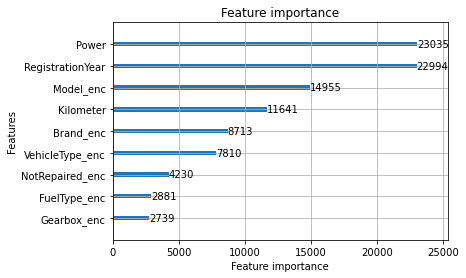

In [80]:
lgb.plot_importance(model_lgbm)

The importance of used variables for the model are well interpreted by common sense. So the model is not a "black box". The age and power of a car are the most important features.

## 2.4 Model 4 - CatBoostRegressor  <a class="anchor" id="step2.4"></a>
[back to content](#content)

Finally, let's make a CatBoost model without a special selection of hyperparameters.

In [81]:
model_catboost = cb.CatBoostRegressor(verbose=0)

In [82]:
cb_train_time = 14.5

In [83]:
cb_rmse_valid = 1714

In [84]:
cb_predict_time = 0.030

The quality of predictions has not improved, but the speed of work is high.

# 3. Model analysis  <a class="anchor" id="step3"></a>
[back to content](#content)

Let's create a pivot table based on the results of the models' work and visualize the metrics:

In [85]:
results = pd.DataFrame({'Model': ['Linear Regression', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'],
                        'RMSE [€]': [reg_rmse_valid, rfr_rmse_valid, lgbm_rmse_valid, cb_rmse_valid],
                        'Training time [s]': [reg_train_time, rfr_train_time, lgbm_train_time, cb_train_time],
                        'Prediction time [s]': [reg_predict_time, rfr_predict_time, lgbm_predict_time, cb_predict_time]})

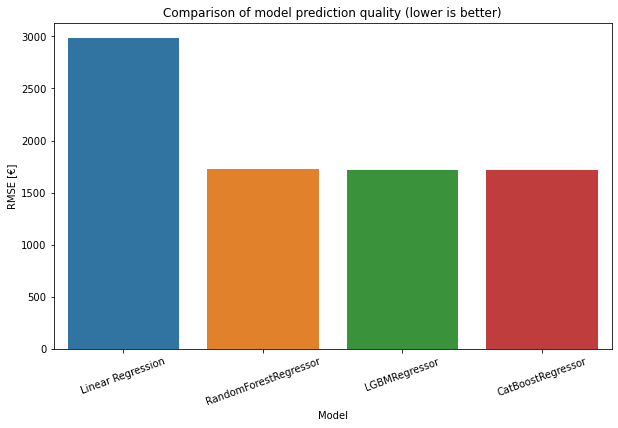

In [90]:
plot_barchart(results, 'Model', 'RMSE [€]',
              'Comparison of model prediction quality (lower is better)',
              'Model', 'RMSE [€]',(10,6), 20)

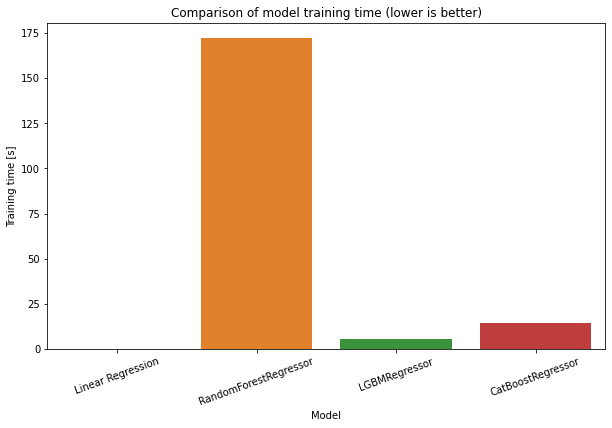

In [91]:
plot_barchart(results, 'Model', 'Training time [s]',
              'Comparison of model training time (lower is better)',
              'Model', 'Training time [s]',(10,6), 20)

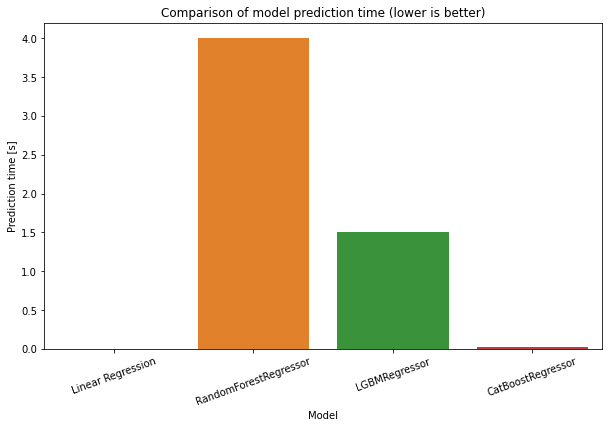

In [92]:
plot_barchart(results, 'Model', 'Prediction time [s]',
              'Comparison of model prediction time (lower is better)',
              'Model', 'Prediction time [s]',(10,6),20)

Linear regression clearly loses out on the RMSE quality metric, but it wins in model training and prediction time. The RMSE metrics are roughly the same for the three models, except for linear regression. The CatBoost algorithm has clear advantages in terms of model prediction time, and the random forest turned out to be the slowest. LGBMRegressor learns quite quickly, but is much slower on predictions, which is very important if you need to work in real time.

Best model in this comparison: **CatBoostRegressor**

## Compare best model with dummy estimator

Using constant prediction from a dataset, let's check how much better the selected model performs.

In [93]:
#save the dummy metrics in variables

rmse_dummy_median = mean_squared_error(
    target_valid, DummyRegressor(strategy='median').fit(
        features_train, target_train).predict(features_valid)) ** 0.5

rmse_dummy_mean = mean_squared_error(
    target_valid, DummyRegressor(strategy='mean').fit(
        features_train, target_train).predict(features_valid)) ** 0.5

In [94]:
#save results in table
dummy_compare = pd.DataFrame({'Model': ['CatBoostRegressor', 'DummyRegresspr (median)', 'DummyRegresspr (mean)'],
                              'RMSE [€]': [cb_rmse_valid,rmse_dummy_median,rmse_dummy_mean]})

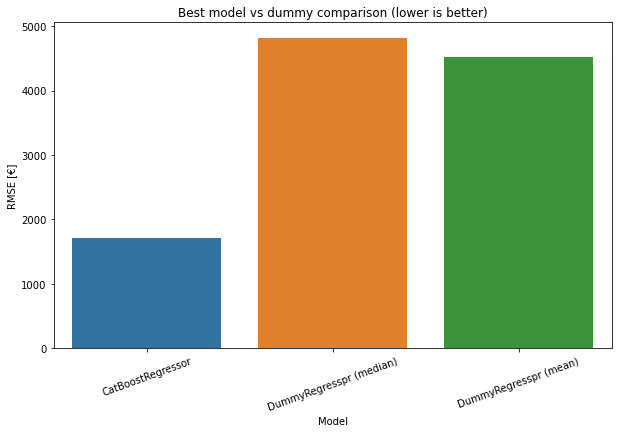

In [96]:
plot_barchart(dummy_compare, 'Model', 'RMSE [€]',
              'Best model vs dummy comparison (lower is better)',
              'Model', 'RMSE [€]',(10,6), 20)

The best model is definitely better than the random one.

# 4. Summary  <a class="anchor" id="step4"></a>
[back to content](#content)

* weighing prediction quality versus performance, the best model is **CatBoostRegressor**
* although we could overcome the dummy model, the RMSE metric still definitely needs some optimization, 1700 € is too big for an error
* what else can be done to improve metrics:
     * try to preprocess data better, fill in the gaps with other algorithm
     * try to add additional features (feature engineering)
     * tune model hyperparameters